In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'

import tensorflow as tf
import numpy as np
tf.reset_default_graph()

random_seed = 42
from numpy.random import seed
seed(random_seed)
from tensorflow import set_random_seed
set_random_seed(random_seed)
import random
random.seed(random_seed)
#print(random.getstate())

from keras import backend as K

with tf.device('/gpu:0'):
    c = tf.random_uniform([], -10, 10)
    d = tf.random_uniform([], -10, 10)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    print(sess.run(c))
    print(sess.run(d))
    
    
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)   
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)    

K.set_session(sess)    
#print(sess)
#config = tf.ConfigProto(
#        device_count = {'GPU': 0}
#    )
#sess = tf.Session(config=config)
# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
# https://stackoverflow.com/questions/45230448/how-to-get-reproducible-result-when-running-keras-with-tensorflow-backend
# https://stackoverflow.com/questions/46836857/results-not-reproducible-with-keras-and-tensorflow-in-python

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


2.7579927
3.7836285


In [2]:
import os
import sys
import warnings

import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras
print(keras.__version__)

2.1.3


In [3]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'data/stage1_train/'
TEST_PATH = 'data/stage1_test/'
DATA_PATH = 'data/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [4]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
print(len(train_ids))
print(len(test_ids))

670
65


In [5]:
current_dir = os.getcwd()
print(current_dir)

/home/chen/workspace/git_examples/kaggle-nuclei-challenge


In [6]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

save_array(DATA_PATH + 'X_train.bc', X_train)
save_array(DATA_PATH + 'Y_train.bc', Y_train)
save_array(DATA_PATH + 'X_test.bc', X_test)

print('Done!')

In [7]:
X_train = load_array(DATA_PATH + 'X_train.bc')
Y_train = load_array(DATA_PATH + 'Y_train.bc')
X_test = load_array(DATA_PATH + 'X_test.bc')

102


/usr/local/lib/python2.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


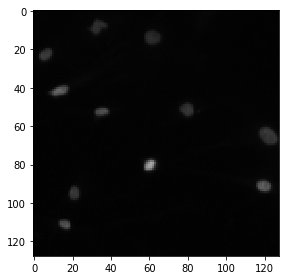

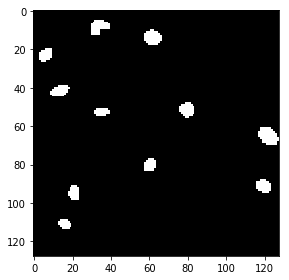

In [8]:
# Check if training data looks all right
ix = np.random.randint(0, len(train_ids))
print(ix)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [9]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [10]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
#model.summary()

In [11]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tmp.h5', verbose=1, save_best_only=True)

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=10, 
                    callbacks=[earlystopper, checkpointer])
K.clear_session()

Train on 603 samples, validate on 67 samples
Epoch 1/10
584/603 [============================>.] - ETA: 0s - loss: 0.5708 - mean_iou: 0.4157
Epoch 00001: val_loss improved from inf to 0.44806, saving model to model-tmp.h5
603/603 [==============================] - 3s 5ms/step - loss: 0.5661 - mean_iou: 0.4160 - val_loss: 0.4481 - val_mean_iou: 0.4246
Epoch 2/10
584/603 [============================>.] - ETA: 0s - loss: 0.3599 - mean_iou: 0.4246
Epoch 00002: val_loss improved from 0.44806 to 0.27867, saving model to model-tmp.h5
603/603 [==============================] - 2s 3ms/step - loss: 0.3580 - mean_iou: 0.4246 - val_loss: 0.2787 - val_mean_iou: 0.4246
Epoch 3/10
584/603 [============================>.] - ETA: 0s - loss: 0.2199 - mean_iou: 0.4380
Epoch 00003: val_loss improved from 0.27867 to 0.20745, saving model to model-tmp.h5
603/603 [==============================] - 2s 3ms/step - loss: 0.2175 - mean_iou: 0.4387 - val_loss: 0.2075 - val_mean_iou: 0.4636
Epoch 4/10
584/603 [===

Train on 603 samples, validate on 67 samples
Epoch 1/10
584/603 [============================>.] - ETA: 0s - loss: 0.5710 - mean_iou: 0.4157
Epoch 00001: val_loss improved from inf to 0.44764, saving model to model-tmp.h5
603/603 [==============================] - 3s 4ms/step - loss: 0.5662 - mean_iou: 0.4160 - val_loss: 0.4476 - val_mean_iou: 0.4246
Epoch 2/10
584/603 [============================>.] - ETA: 0s - loss: 0.3540 - mean_iou: 0.4247
Epoch 00002: val_loss improved from 0.44764 to 0.26642, saving model to model-tmp.h5
603/603 [==============================] - 2s 3ms/step - loss: 0.3524 - mean_iou: 0.4247 - val_loss: 0.2664 - val_mean_iou: 0.4253
Epoch 3/10
584/603 [============================>.] - ETA: 0s - loss: 0.2112 - mean_iou: 0.4416
Epoch 00003: val_loss improved from 0.26642 to 0.20243, saving model to model-tmp.h5
603/603 [==============================] - 2s 3ms/step - loss: 0.2091 - mean_iou: 0.4424 - val_loss: 0.2024 - val_mean_iou: 0.4699
Epoch 4/10
584/603 [============================>.] - ETA: 0s - loss: 0.1762 - mean_iou: 0.4936
Epoch 00004: val_loss improved from 0.20243 to 0.17799, saving model to model-tmp.h5
603/603 [==============================] - 2s 3ms/step - loss: 0.1746 - mean_iou: 0.4942 - val_loss: 0.1780 - val_mean_iou: 0.5151
Epoch 5/10
584/603 [============================>.] - ETA: 0s - loss: 0.1398 - mean_iou: 0.5352
Epoch 00005: val_loss improved from 0.17799 to 0.16356, saving model to model-tmp.h5
603/603 [==============================] - 2s 3ms/step - loss: 0.1403 - mean_iou: 0.5358 - val_loss: 0.1636 - val_mean_iou: 0.5555
Epoch 6/10
584/603 [============================>.] - ETA: 0s - loss: 0.1178 - mean_iou: 0.5721
Epoch 00006: val_loss improved from 0.16356 to 0.13927, saving model to model-tmp.h5
603/603 [==============================] - 2s 3ms/step - loss: 0.1174 - mean_iou: 0.5726 - val_loss: 0.1393 - val_mean_iou: 0.5897
Epoch 7/10
584/603 [============================>.] - ETA: 0s - loss: 0.1064 - mean_iou: 0.6041
Epoch 00007: val_loss improved from 0.13927 to 0.13027, saving model to model-tmp.h5
603/603 [==============================] - 2s 3ms/step - loss: 0.1062 - mean_iou: 0.6045 - val_loss: 0.1303 - val_mean_iou: 0.6181
Epoch 8/10
584/603 [============================>.] - ETA: 0s - loss: 0.0959 - mean_iou: 0.6302
Epoch 00008: val_loss improved from 0.13027 to 0.11765, saving model to model-tmp.h5
603/603 [==============================] - 2s 3ms/step - loss: 0.0953 - mean_iou: 0.6305 - val_loss: 0.1177 - val_mean_iou: 0.6415
Epoch 9/10
584/603 [============================>.] - ETA: 0s - loss: 0.0963 - mean_iou: 0.6507
Epoch 00009: val_loss improved from 0.11765 to 0.11530, saving model to model-tmp.h5
603/603 [==============================] - 2s 3ms/step - loss: 0.0964 - mean_iou: 0.6509 - val_loss: 0.1153 - val_mean_iou: 0.6599
Epoch 10/10
584/603 [============================>.] - ETA: 0s - loss: 0.0869 - mean_iou: 0.6681
Epoch 00010: val_loss improved from 0.11530 to 0.11440, saving model to model-tmp.h5
603/603 [==============================] - 2s 3ms/step - loss: 0.0881 - mean_iou: 0.6684 - val_loss: 0.1144 - val_mean_iou: 0.6762

In [11]:
# Predict on train, val and test
model = load_model('model-tmp.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 0s 610us/step


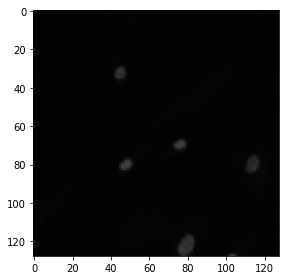

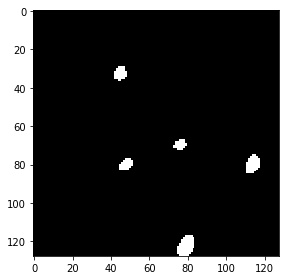

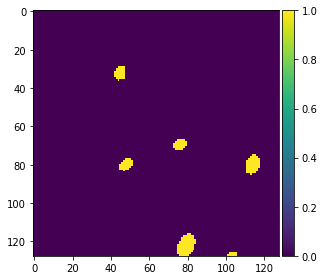

In [12]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

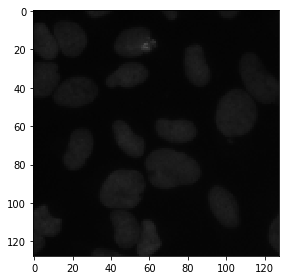

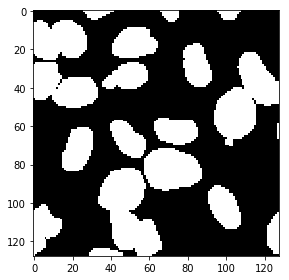

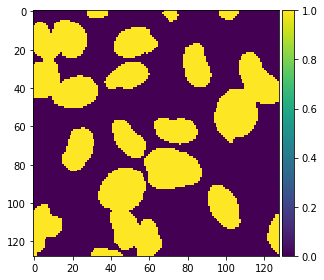

In [13]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [14]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [15]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [18]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-tmp-1.csv', index=False)